# Import Package

In [1]:
# Evaluation Metric Packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Dataset loading Packages
from zipfile import ZipFile
from PIL import Image
from io import BytesIO

# Utilities
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Neural Network Learning Packages
import tensorflow as tf
from tensorflow.keras import backend as K

print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))
tf.random.set_seed(0)

Num GPUs Available:  3


In [2]:
r_seed = 0
np.random.seed(r_seed)

omniglot_data_path = 'data/1_raw/omniglot/images_evaluation.zip'
sample_size = 10000

# Preparing Data

## MNIST and MNIST-Noise and Noise

In [3]:
mnist = tf.keras.datasets.mnist

(x_mnist_train, y_mnist_train), (x_mnist_test,
                                 y_mnist_test) = mnist.load_data()
x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0

# introduce noise to mnist
x_mnist_noise_test = x_mnist_test.copy()
random_noise = np.random.uniform(
    0, 1, x_mnist_noise_test[np.where(x_mnist_noise_test == 0)].shape[0])
x_mnist_noise_test[np.where(x_mnist_noise_test == 0)] = random_noise

x_noise_test = np.random.uniform(0, 1, (sample_size, 28, 28))

In [4]:
for i in range(6):
    im = Image.fromarray(np.uint8(x_mnist_test[i]*255))
    display(im)
    im.save('mnist_{}.pdf'.format(i))
    
for i in range(6):
    im = Image.fromarray(np.uint8(x_mnist_noise_test[i]*255))
    display(im)
    im.save('mniNo_{}.pdf'.format(i))
    
for i in range(6):
    im = Image.fromarray(np.uint8(x_noise_test[i]*255))
    display(im)
    im.save('noise_{}.pdf'.format(i))

## Omniglot

In [5]:
def load_omniglot_eval(data_path):
    omniglot_data_list = []
    with ZipFile(data_path) as zf:
        for filename in zf.namelist():
            if '.png' in filename:
                zip_data = zf.read(filename)
                bytes_io = BytesIO(zip_data)
                pil_img = Image.open(bytes_io)
                pil_img = pil_img.resize((28, 28))
                omniglot_data_list.append([1 - np.array(pil_img) * 1.0])

    omniglot_data = np.concatenate(omniglot_data_list)
    return omniglot_data


omniglot_data = load_omniglot_eval(omniglot_data_path)
sample_idx = np.random.permutation(omniglot_data.shape[0])[:sample_size]
x_omniglot_test = omniglot_data[sample_idx]
print(omniglot_data.shape)

(13180, 28, 28)


In [6]:
for i in range(6):
    im = Image.fromarray(np.uint8(x_omniglot_test[i]*255))
    display(im)
    im.save('omnig_{}.pdf'.format(i))

# Feature Encoding

In [7]:
x_mnist_train = x_mnist_train.reshape(-1, 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)
x_omniglot_test = x_omniglot_test.reshape(-1, 28, 28, 1)
x_mnist_noise_test = x_mnist_noise_test.reshape(-1, 28, 28, 1)
x_noise_test = x_noise_test.reshape(-1, 28, 28, 1)

In [8]:
basic_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3, 3),
                           activation="relu",
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(activation='softmax')
])

# basic_model learning configurations
basic_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# set layer output as a second Model
encoder = tf.keras.models.Model(inputs=basic_model.layers[0].input,
                                outputs=basic_model.layers[-2].output)

K.set_value(basic_model.optimizer.learning_rate, 0.001)
basic_model.fit(x_mnist_train, y_mnist_train, epochs=5)
basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 10s 4ms/step - loss: 0.2386 - accuracy: 0.9255
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0448 - accuracy: 0.9864
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0369 - accuracy: 0.9883
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0272 - accuracy: 0.9911
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0230 - accuracy: 0.9929
313/313 - 1s - loss: 0.0341 - accuracy: 0.9900


[0.03406280651688576, 0.9900000095367432]

In [9]:
e_mnist_train = encoder.predict(x_mnist_train)
e_mnist_test = encoder.predict(x_mnist_test)
e_omniglot_test = encoder.predict(x_omniglot_test)
e_mnist_noise_test = encoder.predict(x_mnist_noise_test)
e_noise_test = encoder.predict(x_noise_test)

# Openset Sample Enrichment

In [10]:
from aosr_utility import sample_enrichment_IF

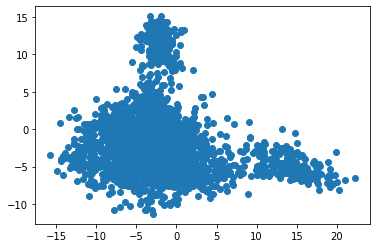

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(198721,)


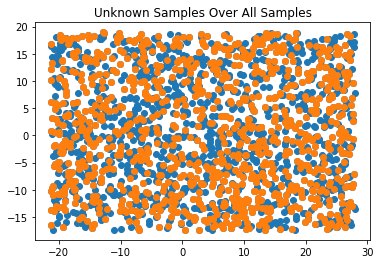

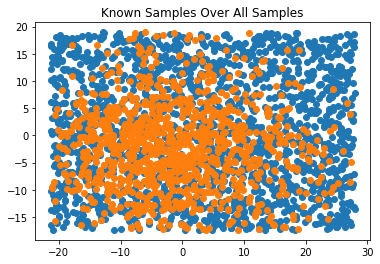

In [11]:
tf.random.set_seed(0)

plt.scatter(e_mnist_train[:2000, 0], e_mnist_train[:2000, 1])
plt.show()

z_q_sample, z_q_weight = sample_enrichment_IF(0, e_mnist_train, 240000)
z_q_weight = 1 - z_q_weight * 1.0

tau = np.sort(z_q_weight)[int(z_q_weight.shape[0] *.1)]

# Unknown Samples
cond1 = (z_q_weight > tau)
cond1 = np.squeeze(cond1)
# Known Samples
cond2 = (z_q_weight <= tau)
cond2 = np.squeeze(cond2)
# Wipe Known Samples
z_q_weight[cond2] = 0
# Balance the weights
z_q_weight = z_q_weight * (z_q_weight.shape[0] / z_q_weight.sum())

plt.scatter(z_q_sample[:2000, 0], z_q_sample[:2000, 1])
plt.scatter(z_q_sample[cond1, 0][:1000], z_q_sample[cond1, 1][:1000])
plt.title('Unknown Samples Over All Samples')
plt.show()
plt.scatter(z_q_sample[:2000, 0], z_q_sample[:2000, 1])
plt.scatter(z_q_sample[cond2, 0][:1000], z_q_sample[cond2, 1][:1000])
plt.title('Known Samples Over All Samples')
plt.show()

# Openset Learning

In [12]:
from aosr_utility import aosr_risk

In [13]:
def mnist_exp(r_seed, beta=0.1):
    # ================================================================== #
    #                                 FYI                                #
    # Design the Open-set Learning Model is a complicated task           #
    # At this stage, we only evaluate the openset learning loss          #
    # How to design proper openset model is consider as our future work  #
    # Since we use the closed-set output as our encoder, the Open-set    # 
    # the Open-set neural network is relatively simple                   #
    # ================================================================== #
    tf.random.set_seed(r_seed)
    detetor = tf.keras.models.Sequential([
        tf.keras.layers.Dense(11),
        tf.keras.layers.Activation(activation='softmax')
    ])

    detetor.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    detetor.fit(e_mnist_train, y_mnist_train * 1.0, epochs=2)

    detetor.compile(optimizer='adam',
                    loss=aosr_risk(detetor, z_q_sample, z_q_weight, e_mnist_train, beta, 10),
                    metrics=['accuracy'])

    K.set_value(detetor.optimizer.learning_rate, 0.001)
    detetor.fit(e_mnist_train, y_mnist_train * 1.0, epochs=25)


    mniTe_pred = detetor.predict(e_mnist_test)
    mniTe_pred = mniTe_pred.argmax(axis=1)
    print('x_mnist_test acc', accuracy_score(y_mnist_test, mniTe_pred))

    mniTr_pred = detetor.predict(e_mnist_train)
    mniTr_pred = mniTr_pred.argmax(axis=1)
    print('x_mnist_train detection rate', (mniTr_pred == 10).sum() / 60000)
    print('x_mnist_test detection rate', (mniTe_pred == 10).sum() / 10000)

    omnig_pred = detetor.predict(e_omniglot_test)
    omnig_pred = omnig_pred.argmax(axis=1)
    print('x_omniglot_test detection rate', (omnig_pred == 10).sum() / 10000)

    mnisN_pred = detetor.predict(e_mnist_noise_test)
    mnisN_pred = mnisN_pred.argmax(axis=1)
    print('x_mnist_noise_test detection rate', (mnisN_pred == 10).sum() / 10000)

    noise_pred = detetor.predict(e_noise_test)
    noise_pred = noise_pred.argmax(axis=1)
    print('x_noise_test detection rate', (noise_pred == 10).sum() / 10000)

    sample_size = 10000
    true_label = np.zeros(sample_size*2) + 10
    true_label[:sample_size] = y_mnist_test

    omnig_f1 = f1_score(true_label, np.concatenate([mniTe_pred,omnig_pred]), average='macro')
    mnisN_f1 = f1_score(true_label, np.concatenate([mniTe_pred,mnisN_pred]), average='macro')
    noise_f1 = f1_score(true_label, np.concatenate([mniTe_pred,noise_pred]), average='macro')

    playground_result = pd.DataFrame()
    playground_result['detector'] = ['aosr_risk']
    playground_result['omnig_f1'] = [omnig_f1]
    playground_result['mnisN_f1'] = [mnisN_f1]
    playground_result['noise_f1'] = [noise_f1]
    return playground_result

## Parameter Beta Analysis

In [14]:
result_list =[]
beta_list = [0.01, 0.02, 0.04, 0.05, 0.08, 0.1, 0.16, 0.32, 0.64]
for beta in beta_list:
    for itr in range(5):
        result_df = mnist_exp(itr, beta)
        result_df['beta'] = beta
        result_list.append(result_df)
result = pd.concat(result_list, axis=0)
print(result.mean())
print(result.std())
result

Epoch 1/2
1875/1875 [==============================] - 2s 806us/step - loss: 1.7279 - accuracy: 0.6840
Epoch 2/2
1875/1875 [==============================] - 2s 824us/step - loss: 0.0331 - accuracy: 0.9917
Epoch 1/25
1875/1875 [==============================] - 5s 2ms/step - loss: 27549180.4470 - accuracy: 0.9928
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1345.5276 - accuracy: 0.9921
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1337.2585 - accuracy: 0.9917
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1316.3108 - accuracy: 0.9920
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1099.5612 - accuracy: 0.9911
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 792.9090 - accuracy: 0.9914
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 552.1084 - accuracy: 0.9894
Epoch 8/25
1875/1875 [==============================] - 4

Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 18.2021 - accuracy: 0.9837
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 7.8857 - accuracy: 0.9853
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 4.6018 - accuracy: 0.9853
Epoch 14/25
1875/1875 [==============================] - 3s 2ms/step - loss: 3.0102 - accuracy: 0.9840
Epoch 15/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9525 - accuracy: 0.9809
Epoch 16/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5057 - accuracy: 0.9784
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3264 - accuracy: 0.9783
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1370 - accuracy: 0.9741
Epoch 19/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9480 - accuracy: 0.9695
Epoch 20/25
1875/1875 [==============================] - 4s 2ms/step - l

1875/1875 [==============================] - 4s 2ms/step - loss: 0.9467 - accuracy: 0.9473
Epoch 23/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9422 - accuracy: 0.9470
Epoch 24/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9476 - accuracy: 0.9469
Epoch 25/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9455 - accuracy: 0.9475
x_mnist_test acc 0.9413
x_mnist_train detection rate 0.05266666666666667
x_mnist_test detection rate 0.0524
x_omniglot_test detection rate 0.7152
x_mnist_noise_test detection rate 0.9967
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 803us/step - loss: 2.4459 - accuracy: 0.6691
Epoch 2/2
1875/1875 [==============================] - 1s 780us/step - loss: 0.0377 - accuracy: 0.9912
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 131470430.4840 - accuracy: 0.9805
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/st

1875/1875 [==============================] - 4s 2ms/step - loss: 9052.9367 - accuracy: 0.9733
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 4578.6062 - accuracy: 0.9719
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2536.2449 - accuracy: 0.9717
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1272.2406 - accuracy: 0.9678
Epoch 8/25
1875/1875 [==============================] - 4s 2ms/step - loss: 631.1067 - accuracy: 0.9646
Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 254.0363 - accuracy: 0.9615
Epoch 10/25
1875/1875 [==============================] - 3s 2ms/step - loss: 100.8725 - accuracy: 0.9591
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 45.2640 - accuracy: 0.9599
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 18.5207 - accuracy: 0.9691
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step -

1875/1875 [==============================] - 4s 2ms/step - loss: 3.8618 - accuracy: 0.9703
Epoch 16/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2.5325 - accuracy: 0.9591
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0194 - accuracy: 0.9550
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7696 - accuracy: 0.9509
Epoch 19/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5398 - accuracy: 0.9436
Epoch 20/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3181 - accuracy: 0.9329
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1785 - accuracy: 0.9266
Epoch 22/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1281 - accuracy: 0.9226
Epoch 23/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1211 - accuracy: 0.9195
Epoch 24/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1168 -

x_mnist_noise_test detection rate 0.9992
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 788us/step - loss: 2.6221 - accuracy: 0.6318
Epoch 2/2
1875/1875 [==============================] - 1s 798us/step - loss: 0.0403 - accuracy: 0.9901
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 81538863.2281 - accuracy: 0.9945
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 21437.0880 - accuracy: 0.9935
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 21132.0093 - accuracy: 0.9938
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 20179.7122 - accuracy: 0.9940
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 12685.3277 - accuracy: 0.9946
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 8461.0499 - accuracy: 0.9939
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 5867.94

1875/1875 [==============================] - 4s 2ms/step - loss: 473.8375 - accuracy: 0.9900
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 199.8387 - accuracy: 0.9873
Epoch 11/25
1875/1875 [==============================] - 3s 2ms/step - loss: 87.9897 - accuracy: 0.9838
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 40.1132 - accuracy: 0.9777
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 20.4119 - accuracy: 0.9680
Epoch 14/25
1875/1875 [==============================] - 4s 2ms/step - loss: 10.9455 - accuracy: 0.9567
Epoch 15/25
1875/1875 [==============================] - 4s 2ms/step - loss: 6.0674 - accuracy: 0.9408
Epoch 16/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3.8393 - accuracy: 0.9332
Epoch 17/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2.6163 - accuracy: 0.9307
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step - loss: 

1875/1875 [==============================] - 4s 2ms/step - loss: 1.8416 - accuracy: 0.8511
Epoch 21/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6030 - accuracy: 0.8278
Epoch 22/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5228 - accuracy: 0.8127
Epoch 23/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5170 - accuracy: 0.8123
Epoch 24/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5075 - accuracy: 0.8092
Epoch 25/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5072 - accuracy: 0.8077
x_mnist_test acc 0.8234
x_mnist_train detection rate 0.18338333333333334
x_mnist_test detection rate 0.174
x_omniglot_test detection rate 0.891
x_mnist_noise_test detection rate 1.0
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 757us/step - loss: 2.3015 - accuracy: 0.6751
Epoch 2/2
1875/1875 [==============================] - 1s 777us/step - loss: 

1875/1875 [==============================] - 4s 2ms/step - loss: 212853.2279 - accuracy: 0.9949
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 209349.0830 - accuracy: 0.9948
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 131106.0924 - accuracy: 0.9941
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 87183.3604 - accuracy: 0.9940
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 38101.7422 - accuracy: 0.9936
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 17667.0068 - accuracy: 0.9937
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 7601.7228 - accuracy: 0.9918
Epoch 9/25
1875/1875 [==============================] - 3s 2ms/step - loss: 3490.5452 - accuracy: 0.9916
Epoch 10/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1265.3787 - accuracy: 0.9902
Epoch 11/25
1875/1875 [==============================] -

,detector,omnig_f1,mnisN_f1,noise_f1,beta
0,aosr_risk,0.801949,0.976171,0.982016,0.01
0,aosr_risk,0.803361,0.976303,0.982745,0.01
0,aosr_risk,0.798410,0.976121,0.982557,0.01
0,aosr_risk,0.800470,0.977209,0.982921,0.01
0,aosr_risk,0.799651,0.975887,0.982236,0.01
0,aosr_risk,0.826549,0.973318,0.976678,0.02
0,aosr_risk,0.827775,0.975005,0.978370,0.02
0,aosr_risk,0.823927,0.974997,0.978551,0.02
0,aosr_risk,0.827621,0.975208,0.978482,0.02
0,aosr_risk,0.825115,0.973505,0.977296,0.02


In [15]:
result.to_csv('mnist_exp_result.csv')